In [29]:
 #تثبيت المكتبات
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


In [30]:
#تحميل ملف ال cvs
!gdown --id 1ISNAPvxCQd7TSCmRHxJSRLrMfMFs5iT5
df = pd.read_csv('mnist_test.csv')

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ISNAPvxCQd7TSCmRHxJSRLrMfMFs5iT5
To: /content/mnist_test.csv
100% 18.3M/18.3M [00:00<00:00, 91.9MB/s]


/tmp/ipython-input-1863251267.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [31]:
# التحقق من عدد الصور، عدد الفئات، قبل التدريب
df.info()
print("عدد الصور:", len(df))
print("عدد الفئات:", df['label'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 785 entries, label to pixel784
dtypes: object(785)
memory usage: 59.9+ MB
عدد الصور: 10001
عدد الفئات: 21


In [32]:
# عدد القيم المفقودة في كل عمود
print(df.isnull().sum())          # عدد القيم المفقودة في كل عمود
print("إجمالي القيم المفقودة:", df.isnull().sum().sum())


label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
إجمالي القيم المفقودة: 0


In [33]:
#  وعرض اول خمس صفوف
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:

# حوّل كل الأعمدة من pixel1 إلى pixel784 إلى أرقام
for col in df.columns[1:]:  # استثناء العمود الأول "label"
    df[col] = pd.to_numeric(df[col], errors='coerce')

# الآن احسب أكبر وأصغر قيمة من الأعمدة الرقمية
numeric_df = df.select_dtypes(include=[np.number])
print("أكبر قيمة:", numeric_df.max().max())
print("أصغر قيمة:", numeric_df.min().min())



أكبر قيمة: 255.0
أصغر قيمة: 0.0


In [35]:
#  عدد الصفوف والاعمدة
df.shape

(10001, 785)

In [36]:
df = df.dropna(subset=['label'])
X = df.drop(columns=['label'])
y = df['label']


In [37]:
# تأكد أن العمود label رقمي
df['label'] = pd.to_numeric(df['label'], errors='coerce')

# الآن احسب عدد العينات لكل فئة
class_counts = df['label'].value_counts().sort_index()

print(class_counts)


label
0.0     980
1.0    1135
2.0    1032
3.0    1010
4.0     982
5.0     892
6.0     958
7.0    1028
8.0     974
9.0    1009
Name: count, dtype: int64


In [38]:
# فصل البيانات
X = df.drop("label", axis=1)
y = df["label"]

In [40]:
# تقسيم البيانات إلى مجموعات تدريب، تحقق، واختبار

# إزالة الصفوف التي تحتوي على قيم NaN في y
# هذا يضمن أيضًا إزالة الصفوف المقابلة في X
nan_mask = y.notna()
X_cleaned = X[nan_mask]
y_cleaned = y[nan_mask]

#  فصل 70% للتدريب و30% مؤقت (للاحق تقسيمه للتحقق والاختبار)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_cleaned, test_size=0.30, random_state=42, stratify=y_cleaned
)
# تقسيم الـ30% المؤقتة إلى 15% تحقق و15% اختبار
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# طباعة الأحجام للتأكد
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (7000, 784) (7000,)
Validation set: (1500, 784) (1500,)
Test set: (1500, 784) (1500,)


In [41]:
 #  التأكد من أن كل أعمدة X رقمية
X = X.astype(float)  # تحويل جميع البكسلات إلى float

# ثم تطبيع القيم لتكون بين 0 و1
X = X / 255.0

# التحقق من نطاق القيم بعد التطبيع
print("Pixel range after normalization:")
print("Min:", X.min().min(), "Max:", X.max().max())

Pixel range after normalization:
Min: 0.0 Max: 1.0


In [42]:
#التأكد من عمود الأرقام لن يتأثر بال normalization
print(y.head(10))


0    NaN
1    7.0
2    2.0
3    1.0
4    0.0
5    4.0
6    1.0
7    4.0
8    9.0
9    5.0
Name: label, dtype: float64


In [43]:
# التأكد أن جميع القيم رقمية
X_train = X_train.astype(float)
X_val   = X_val.astype(float)
X_test  = X_test.astype(float)

# التطبيع لتكون القيم بين 0 و 1
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0

# التحقق من نطاق القيم بعد التطبيع
print("Training set pixel range: Min =", X_train.min().min(), "Max =", X_train.max().max())
print("Validation set pixel range: Min =", X_val.min().min(), "Max =", X_val.max().max())
print("Test set pixel range: Min =", X_test.min().min(), "Max =", X_test.max().max())

Training set pixel range: Min = 0.0 Max = 1.0
Validation set pixel range: Min = 0.0 Max = 1.0
Test set pixel range: Min = 0.0 Max = 1.0


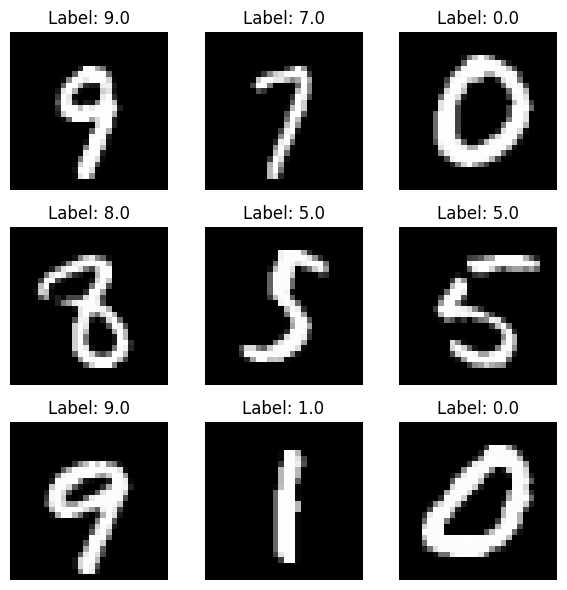

In [44]:
# عرض 9 صور من بيانات التدريب
plt.figure(figsize=(6,6))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train.iloc[i].values.reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [45]:
#استيراد النموذج
from sklearn.linear_model import LogisticRegression

In [46]:

#انشاء النموذج
log_model = LogisticRegression(max_iter=1000)

In [47]:
from sklearn.preprocessing import StandardScaler

# إنشاء الكائن
scaler = StandardScaler()

# تدريب الـ scaler على بيانات التدريب وتحويلها
X_train_scaled = scaler.fit_transform(X_train)

# تحويل بيانات الفاليديشن والاختبار بنفس الـ scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# الآن تقدر تدرب النموذج
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

Accuracy (Logistic Regression): 0.886
Confusion Matrix (Logistic Regression):
 [[139   0   0   0   0   1   3   1   2   1]
 [  0 166   2   0   0   1   0   0   1   0]
 [  2   1 133   4   3   1   2   4   5   0]
 [  1   1   0 139   1   3   0   2   3   2]
 [  0   0   1   1 127   1   5   0   1  11]
 [  0   2   0   7   2 109   4   4   5   1]
 [  3   0   2   0   3   5 129   1   1   0]
 [  0   0   3   2   1   0   0 140   0   8]
 [  1   4   3   3   0   9   1   2 116   7]
 [  1   1   1   2   5   2   0   4   4 131]]

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       147
         1.0       0.95      0.98      0.96       170
         2.0       0.92      0.86      0.89       155
         3.0       0.88      0.91      0.90       152
         4.0       0.89      0.86      0.88       147
         5.0       0.83      0.81      0.82       134
         6.0       0.90      0.90      0.90       144
         7

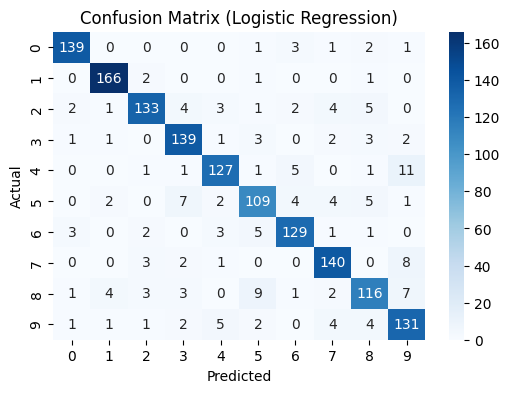

In [48]:
# الحصول على التوقعات من النموذج اللوجستي
y_pred_log = log_model.predict(X_test_scaled)

# التقييم
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_log))

# إنشاء وعرض مصفوفة الالتباس
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

In [49]:
# --- فحص التحيز لكل رقم بطريقة صحيحة ---
def check_digit_bias(y_true, y_pred):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    # نسبة التعرف الصحيح لكل رقم
    bias_per_digit = df.groupby('y_true').apply(lambda g: (g['y_pred'] == g['y_true']).mean())
    return bias_per_digit

print("\nLogistic Regression Bias per digit:")
print(check_digit_bias(y_test, y_pred_log))



Logistic Regression Bias per digit:
y_true
0.0    0.945578
1.0    0.976471
2.0    0.858065
3.0    0.914474
4.0    0.863946
5.0    0.813433
6.0    0.895833
7.0    0.909091
8.0    0.794521
9.0    0.867550
dtype: float64


/tmp/ipython-input-3791260319.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_per_digit = df.groupby('y_true').apply(lambda g: (g['y_pred'] == g['y_true']).mean())


In [50]:
# تقييم نموذج الانحدار اللوجستي باستخدام 5-fold Cross Validation
# هذا يقسم مجموعة التدريب إلى 5 أجزاء، كل جزء يستخدم مرة للاختبار وأربع مرات للتدريب
scores = cross_val_score(log_model, X_train, y_train, cv=5)

print("Cross Validation Scores:", scores)
print("Average Accuracy:", scores.mean())

Cross Validation Scores: [0.90857143 0.90071429 0.89642857 0.91       0.91285714]
Average Accuracy: 0.9057142857142857


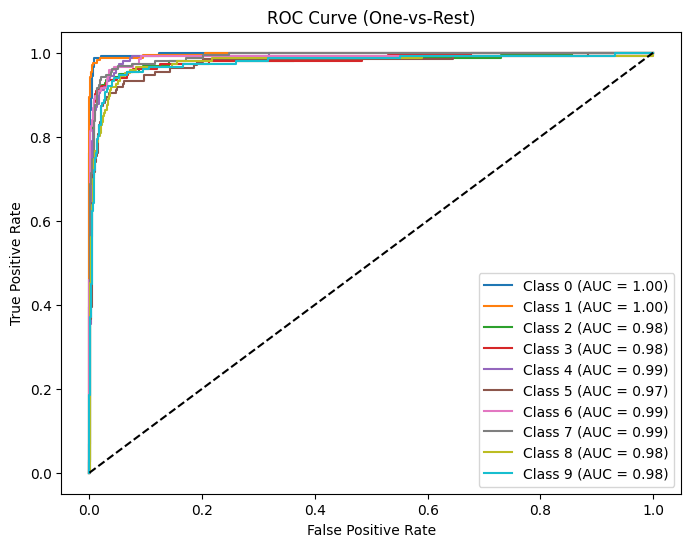

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# تحويل y_test إلى شكل ثنائي (one-hot)
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_test_bin.shape[1]

# الحصول على احتمالات التوقع
y_proba = log_model.predict_proba(X_test_scaled)

# رسم ROC لكل فئة
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')  # خط عشوائي
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()